In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io as sio
from astropy.io import fits
from skimage import transform

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="2"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))



True
1
0
NVIDIA A100-PCIE-40GB


In [2]:
import large_scale_UQ as luq



Using device: cuda


In [3]:

repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
img_name = 'W28' # 'M31'


# Define my torch types (CRR requires torch.float32)
myType = torch.float32
myComplexType = torch.complex64


In [7]:
img_names = ['M31', 'W28', 'CYN', '3c288']
cai_sigmas = [0.00238816, 0.0011778, 0.00056929, 0.00221527]

for it, img_name in enumerate(img_names):

    # Load image and mask
    img, mat_mask = luq.helpers.load_imgs(img_name, repo_dir)

    # Aliases
    x = img
    ground_truth = img

    torch_img = torch.tensor(
        np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape
    )

    phi = luq.operators.MaskedFourier_torch(
        shape=img.shape, 
        ratio=0.5 ,
        mask=mat_mask,
        norm='ortho',
        device=device
    )

    y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()


    input_snr = 30
    num_measurements = y[y!=0].shape[0]

    my_sigma_inf = 10**(-input_snr/20)*(np.linalg.norm(y.flatten(),ord=np.inf)/np.sqrt(num_measurements))
    print(img_name, ', my_sigma_inf: \t', my_sigma_inf)

    my_sigma = 10**(-input_snr/20)*(np.linalg.norm(y.flatten(),ord=2)/np.sqrt(num_measurements))
    print(img_name, ', my_sigma: \t', my_sigma)
    print(img_name, ', my_sigma/sqrt(2): ', my_sigma/np.sqrt(2))
    eff_sigma = luq.helpers.compute_complex_sigma_noise(y, input_snr)
    print(img_name, ', eff_sigma: \t', eff_sigma)

    print(img_name, ', cai_sigmas: \t', cai_sigmas[it], '\n')
    

    # Generate noise
    # Generate noise
    rng = np.random.default_rng(seed=0)
    n_re = rng.normal(0, eff_sigma, y[y!=0].shape)
    n_im = rng.normal(0, eff_sigma, y[y!=0].shape)
    # Add noise
    y[y!=0] += (n_re + 1.j*n_im)

    # Observation
    torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
    x_init = torch.abs(phi.adj_op(torch_y))


M31 , my_sigma_inf: 	 0.00227443438077094
M31 , my_sigma: 	 0.005426908705817896
M31 , my_sigma/sqrt(2):  0.003837403946764144
M31 , eff_sigma: 	 0.003837403946764144
M31 , cai_sigmas: 	 0.00238816 

W28 , my_sigma_inf: 	 0.00039222997863391725
W28 , my_sigma: 	 0.0023034582809650897
W28 , my_sigma/sqrt(2):  0.0016287909706507225
W28 , eff_sigma: 	 0.0016287909706507225
W28 , cai_sigmas: 	 0.0011778 

CYN , my_sigma_inf: 	 0.0005290248316322915
CYN , my_sigma: 	 0.0012368039961337801
CYN , my_sigma/sqrt(2):  0.0008745524926648164
CYN , eff_sigma: 	 0.0008745524926648164
CYN , cai_sigmas: 	 0.00056929 

3c288 , my_sigma_inf: 	 0.004198442575835211
3c288 , my_sigma: 	 0.0059077626700848335
3c288 , my_sigma/sqrt(2):  0.00417741904565773
3c288 , eff_sigma: 	 0.00417741904565773
3c288 , cai_sigmas: 	 0.00221527 



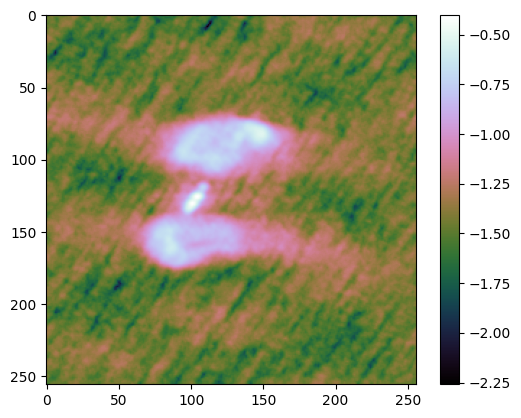

/tmp/ipykernel_2444470/4204744195.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(img)), cmap='cubehelix')


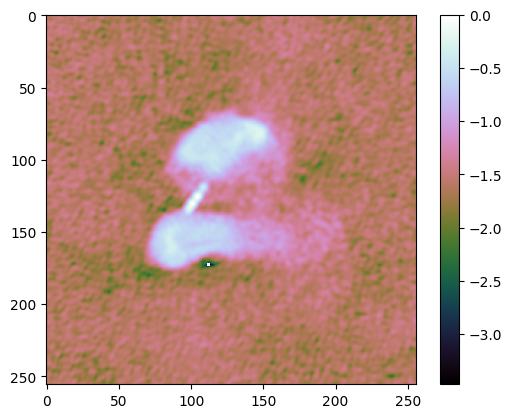

In [16]:
plt.figure()
plt.imshow(np.log10(np.abs(luq.utils.to_numpy(x_init))), cmap='cubehelix')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.log10(np.abs(img)), cmap='cubehelix')
plt.colorbar()
plt.show()

In [125]:



def new_load_imgs(img_name, repo_dir):
    """Load radio images.
    
    Load radio image and the corresponding Fourier mask.
    The preprocessing follows X. Cai's implementation used for his article.

    Args:
        img_name (str): Radio image name
        repo_dir (str): path to the repository directory

    Returns:
        img (np.ndarray): preprocessed radio image
        mat_mask (np.ndarray): Fourier mask
    """
    # Load img
    img_path = repo_dir + '/data/imgs/{:s}.fits'.format(img_name)
    img_data = fits.open(img_path, memmap=False)

    # Loading the image and cast it to float
    img = np.squeeze(np.copy(img_data[0].data)).astype(np.float64)
    # Flipping data
    img = np.flipud(img)

    # Resize image 
    if img_name == 'CYN':
        img = transform.resize(img, [256, 512], order=3, anti_aliasing=True)

    if img_name == 'W28' or img_name == '3c288':
        img = transform.resize(img, [256, 256], order=3, anti_aliasing=True)

    # Normalise
    img = img - np.min(img)
    img = img / np.max(img)

    # Enforce positivity
    img[img<0] = 0

    # Threshold imgs
    if img_name == 'CYN':
        th = 0.0004
        img[img<th] = 0
    elif img_name == 'W28':
        th = 0.022
        img[img<th] = 0
    elif img_name == '3c288':
        th = 0.035
        img[img<th] = 0


    # Load op from X Cai
    op_mask = sio.loadmat(
        repo_dir + '/data/operators_masks/' + img_name + '_fourier_mask.mat'
    )['Ma']

    # Matlab's reshape works with 'F'-like ordering
    mat_mask = np.reshape(np.sum(op_mask, axis=0), img.shape, order='F').astype(bool)

    return img, mat_mask

def compute_uv_noise_sigma(input_snr, img):
    return 10.**(-input_snr/20.)*np.max(np.abs(img))
    

In [126]:
new_img, mat_mask = new_load_imgs('W28', repo_dir)


In [95]:
y[y!=0].shape[0]

6511

In [97]:
y.shape

(256, 256)

In [134]:
input_snr = 30
num_measurements = y[y!=0].shape[0]

my_sigma_inf = 10**(-input_snr/20)*(np.linalg.norm(y.flatten(),ord=np.inf)/np.sqrt(num_measurements))
print(my_sigma_inf)

my_sigma = 10**(-input_snr/20)*(np.linalg.norm(y.flatten(),ord=2)/np.sqrt(num_measurements))
print(my_sigma)


0.00039222997863391725
0.0023034582809650897


In [116]:
print(compute_uv_noise_sigma(input_snr=30, img=img))

print(compute_uv_noise_sigma(input_snr=30, img=new_img))


0.03162277660168379
0.03162277660168379


In [86]:
img

array([[2.86008980e-06, 1.12736161e-06, 2.01604994e-06, ...,
        6.78100294e-08, 5.21632285e-11, 9.31633299e-12],
       [5.12101210e-06, 2.76522451e-06, 2.91413009e-06, ...,
        2.01539492e-08, 2.38343901e-11, 9.32586089e-12],
       [7.35442879e-06, 4.84125689e-06, 3.30955507e-06, ...,
        2.64410646e-11, 9.06748701e-12, 9.32546898e-12],
       ...,
       [1.04945297e-05, 1.12096690e-05, 1.24897613e-05, ...,
        1.57768055e-04, 1.57115269e-04, 1.03528090e-04],
       [8.20954784e-06, 9.28299717e-06, 1.03317321e-05, ...,
        6.57403377e-05, 8.13660679e-05, 7.96733662e-05],
       [3.92182619e-06, 5.06171145e-06, 5.27472575e-06, ...,
        3.16108036e-05, 4.62900946e-05, 5.26797535e-05]])

In [118]:


np.min(cai_W28_im[cai_W28_im!=0])

0.022000017816117906

/tmp/ipykernel_2440630/1905173300.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(img)), cmap='cubehelix')


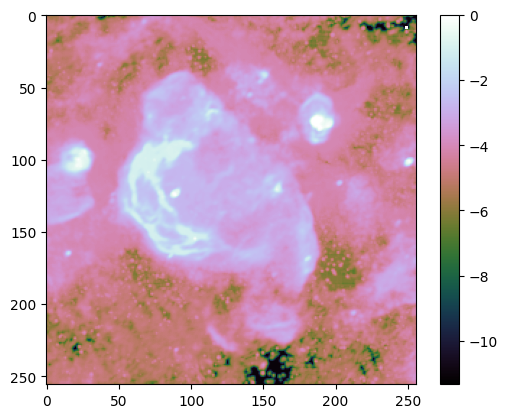

/tmp/ipykernel_2440630/1905173300.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(new_img)), cmap='cubehelix')


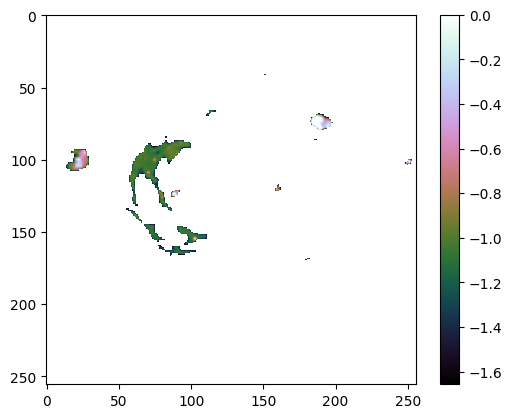

/tmp/ipykernel_2440630/1905173300.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(cai_W28_im)), cmap='cubehelix')


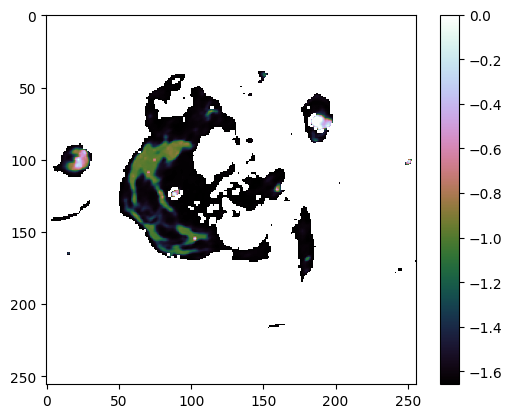

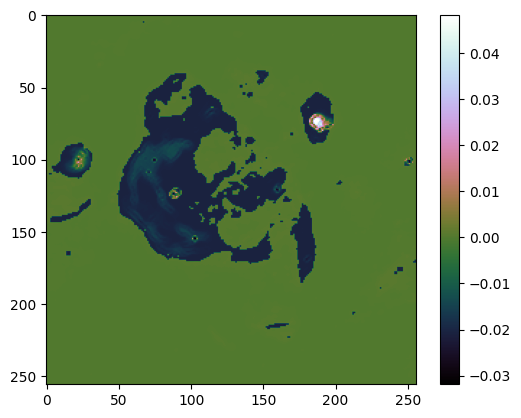

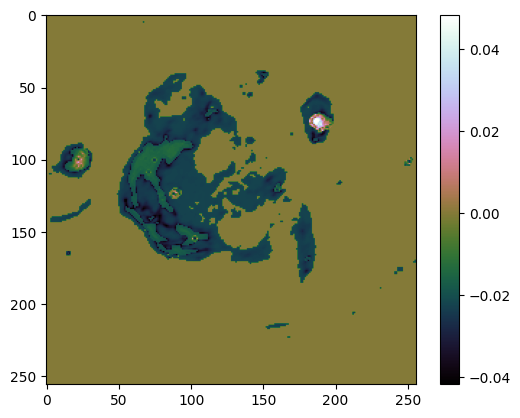

In [128]:

plt.figure()
plt.imshow(np.log10(np.abs(img)), cmap='cubehelix')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.log10(np.abs(new_img)), cmap='cubehelix')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.log10(np.abs(cai_W28_im)), cmap='cubehelix')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(img - cai_W28_im, cmap='cubehelix')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(new_img - cai_W28_im, cmap='cubehelix')
plt.colorbar()
plt.show()


In [77]:
img[img<0.022].shape

(63835,)

In [76]:
img.size

65536

In [35]:
np.max(np.abs(img))


1.0

In [22]:
mat_data_dir = '/disk/xray0/tl3/repos/src_proxmcmc/code/data/' 



In [27]:
M31_mat_contents = sio.loadmat(mat_data_dir + 'M31_mat_syn/M31_measure_noise')

print(M31_mat_contents.keys())

cai_sigma = M31_mat_contents['sigma_noise']
cai_y = M31_mat_contents['sigma_noise']

dict_keys(['__header__', '__version__', '__globals__', 'sigma_noise', 'y'])


array([[0.00238816]])

In [81]:

W28_mat_contents = sio.loadmat(mat_data_dir + 'W28_mat_syn/W28_measure_noise')
print(W28_mat_contents.keys())
print(W28_mat_contents['sigma_noise'])

W28_im_contents = sio.loadmat(mat_data_dir + 'W28_mat_syn/W28_data_org')
print(W28_im_contents.keys())
cai_W28_im = W28_im_contents['im']



dict_keys(['__header__', '__version__', '__globals__', 'sigma_noise', 'y'])
[[0.0011778]]
dict_keys(['__header__', '__version__', '__globals__', 'im'])


In [29]:
CYN_mat_contents = sio.loadmat(mat_data_dir + 'CYN_mat_syn/CYN_measure_noise')

print(CYN_mat_contents.keys())

CYN_mat_contents['sigma_noise']


dict_keys(['__header__', '__version__', '__globals__', 'sigma_noise', 'y'])


array([[0.00056929]])

In [30]:
_3c288_mat_contents = sio.loadmat(mat_data_dir + '3c288_mat_syn/3c288_measure_noise')

print(_3c288_mat_contents.keys())

_3c288_mat_contents['sigma_noise']



dict_keys(['__header__', '__version__', '__globals__', 'sigma_noise', 'y'])


array([[0.00221527]])